## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [58]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [59]:
# read the dataset & displaying a sample
df=pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [60]:
# check the number of rows & dataset shape
df.shape[0]

294478

c. The number of unique users in the dataset.

In [61]:
# check the number of unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [62]:
# proportion of users converted.
convert=df['converted']==1
total_converted=convert.sum()
total_converted

35237

In [63]:
converted_pro=total_converted/df['converted'].count()
converted_pro

0.11965919355605512

In [64]:
#  proportion of users converted with other function
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [65]:
# The number of times the treatment don't line up
no_treatment=len(df.query("group!= 'treatment'& landing_page == 'new_page'"))
no_treatment

1928

In [66]:
# The number of times the new_page don't line up
no_new_page= len(df.query("group =='treatment' & landing_page != 'new_page'"))
no_new_page

1965

In [67]:
# The number of times the new_page and treatment don't line up
total_line_up= no_treatment + no_new_page
total_line_up

3893

f. Do any of the rows have missing values?

In [68]:
# check the missing data
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [120]:
# restore the dataset with df2
df2=df.copy()
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [121]:
df2.shape

(294478, 5)

In [122]:
# remove the rows  treatment is not aligned with new_page or control is not aligned with old_page
df2=df[((df['group']=='treatment') & (df['landing_page']=='new_page'))| ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [123]:
# check the dataset shape after filteration
df2.shape

(290585, 5)

In [124]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [125]:
# unique user_ids are in df2
df2['user_id'].nunique()

290584

In [126]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [127]:
# check the dataset shape
df2.shape

(290585, 5)

In [128]:
# Check how many rows have same userid
df2.user_id.duplicated(keep=False).sum()

2

b. There is one **user_id** repeated in **df2**.  What is it?

In [129]:
# user_id repeated in df2
repeated_id=df2.user_id[df2['user_id'].duplicated()]
repeated_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [130]:
#display rows which has same data(duplicated)
df2[df2['user_id'].duplicated(keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [131]:
df2=df2.drop(index=2893)

In [133]:
df2.shape

(290584, 5)

In [134]:
#delete duplicate data fo# Now we remove duplicate rows
df2 = df2.drop_duplicates()
# Check agin if duplicated values are deleted or not
sum(df2.duplicated())

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [135]:
# probability of an individual converting
p_convert=df2.converted.mean()
p_convert

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [136]:
# probability of an individual  control group converting
p_control=df2.query("group=='control'").converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [137]:
# individual was in the treatment group
p_treatment= df2.query("group=='treatment'").converted.mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [138]:
# probability that an individual received the new page
len(df2[df2['landing_page']=='new_page'])/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**From above, the propability of an individual converted is 11.9 % , the propability of a individual control group page is 12% and propability of an individaul treatment group page is 11.8 %, so from the analysis will find all the percentage is very close, this is not sufficient evidence to say the new treatment page lead to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**               $H_{o}$: $p_{new}$ - $p_{old}$ <= 0 **

**               $H_{1}$: $p_{new}$ - $p_{old}$ > 0.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [139]:
# display sample from dataset
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [140]:
# null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate 
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [141]:
# null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate 
p_old= df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [142]:
#number of individul new page
n_new=df2.query("landing_page=='new_page'").landing_page.count()
n_new

145310

d. What is $n_{old}$?

In [143]:
##number of individul new page
n_old= df2.query("landing_page=='old_page'").landing_page.count()
n_old

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [144]:
# Simulate  𝑛𝑛𝑒𝑤  transactions with a convert rate of  𝑝𝑛𝑒𝑤  under the null
new_page_convert= np.random.binomial(1,p_new,n_new)
new_page_converted=new_page_convert.mean()
new_page_converted

0.11840203702429289

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [145]:
#Simulate  𝑛𝑜𝑙𝑑  transactions with a convert rate of  𝑝𝑜𝑙𝑑  under the null.
old_page_converte=np.random.binomial(1,p_old,n_old)
old_page_converted=old_page_converte.mean()
old_page_converted

0.12020044880708179

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [146]:
obs_diff=new_page_converted - old_page_converted
obs_diff

-0.001798411782788903

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [147]:
#Simulate 10,000  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  values using this same process similarly to the one you calculated & store NP array
    
new_page_converted_10000= np.random.binomial(n_new,p_new,size=10000)/n_new
new_page_converted_10000

array([0.1191728 , 0.12028766, 0.11961324, ..., 0.12104466, 0.11920033,
       0.12006056])

In [148]:
old_page_converted_10000= np.random.binomial(n_old,p_old,size=10000)/n_old
old_page_converted_10000

array([0.1201385 , 0.11920233, 0.12058593, ..., 0.12162534, 0.11900271,
       0.11942949])

In [149]:
# p_diffs 
p_diffs= new_page_converted_10000 - old_page_converted_10000
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

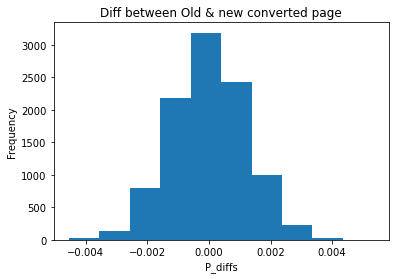

In [150]:
#plot hist of the p_diffs
plt.hist(p_diffs);
plt.title( 'Diff between Old & new converted page');
plt.xlabel('P_diffs');
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [151]:
# calcul avg new page converted
df_new_page_obs=df2.query("landing_page=='new_page'").converted.mean()

In [152]:
# calcul avg_old_page_converted
df_old_page_obs=df2.query("landing_page=='old_page'").converted.mean()

In [153]:
diff_obs= df_new_page_obs- df_old_page_obs
diff_obs

-0.0015782389853555567

In [154]:
#  proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
p_vals=(p_diffs>diff_obs).mean()
p_vals

0.9049

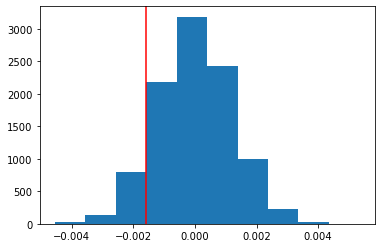

In [155]:
plt.hist(p_diffs);
plt.axvline(x=diff_obs,c='red');

### form the cell above will find p_diff greater than actual difference by 90.9 %  

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### from  above the p-diff > diff_obs by 90 %, ( fail to reject null hypothesis test).
#### p_value is greater than alpha so that (fail to reject null hypothesis test).
#### Also don't have a  sufficient evidence that the new_page has a higher conversion rate than the old_page 


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [156]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [157]:
import statsmodels.api as sm

convert_old = (df2.query("group=='control'")['converted']).sum()
convert_new = (df2.query("group=='treatment'")['converted']).sum()
n_old = len(df2.query('group=="control"'))
n_new = len(df2.query('group=="treatment"'))

In [158]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [159]:
# calc the z score
z_score, p_value=sm.stats.proportions_ztest([convert_old, convert_new], [n_old,n_new], value=None,alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**from above can find the z-score get us 1.31 stander deviation from the mean with 90.5 % p_value with (alpha = 0.05) so all of this support our previous opinion fail to reject the null Hypothesis test and keep the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Using Logistic regression because we have binary varaibal (converted & not converted).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [160]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [161]:
# create fit model
ml= sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [162]:
# data summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:               8.077e-06
Time:                        01:53:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**the results summary p _value = 19% this less fidderent than part 2 , because in the logistic regression use 2 side tail due

**               $H_{o}$: $p_{new}$ - $p_{old}$ = 0 **

**               $H_{1}$: $p_{new}$ - $p_{old}$ \ neq 0.**



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

##### Add an other factors to the regrssion model will increaseing the chance to determien the infulance of one or more perdictor variables.**
#####  this disadvantages  to adding additional terms into regression model depend on the type of this model, only bulid the relation between 2 variable or best predication fro response & which input.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [163]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [164]:
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [165]:
countries_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [166]:
# Merge the 2 data set.
df3= countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head(5)


,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [167]:
# create dummies values 
df3['intercept']=1
df3[['US', 'UK', "CA"]] = pd.get_dummies(df3['country'])
df3.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [168]:
# create the interaction btween page & countries using Ca as base line
df3['US_page']= df3['ab_page'] * df3['US']
df3['UK_page']= df3['ab_page'] * df3 ['UK']

In [169]:
ml= sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'US_page','UK_page']])
results=ml.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:               3.482e-05
Time:                        01:53:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

### No significant effects on conversion

<a id='conclusions'></a>
## Conclusions

On this is project, we are making A/B test for e- commerce websit. to decision if the company will implement the new page, keep the old page or the result need to experiment for long time to make a decision by using regression.

Part I-->
         Probability of an individual converting regardless of the page is 11.9 %, when control group is 12 % & treatment group is 11.8 %. the both of them is very close from each other, and this is not sufficient evidence to say any one of them can lead to more conversion.

PartII--> 
          From A/B test the p-diff > diff_obs by 90 %, ( fail to reject null hypothesis test),p_value is greater than alpha so that (also fail to reject null hypothesis test), Also don't have a sufficient evidence that the new_page has a higher conversion rate than the old_page.
        
part III-->
            From the logist regression approach, the p_ value 19 % with two side tail there is no significant can effect in page conversion.

Aftar using probaplity, A/B test and Logistic regression model on ab_page dataset we got confimation for old page equal or better than new page our advice to keep old page. 
when add other factors like (countries) into regression model to increase the ability to determine the influence of one or more predictor variable ,found the no significant effect for interaction between conversion & countries.

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.